In [1]:
%matplotlib inline
%time from hikyuu.interactive.interactive import *
import datetime
#use_draw_engine('echarts')

Wall time: 7.32 s


# 策略分析

## 原始描述

买入条件：周线MACD零轴下方底部金叉买入30%

卖出条件：日线级别 跌破 20日线 卖出50%持仓


## 策略分析

市场环境：无

系统有效性：无

信号指示器：
- 买入信号：周线MACD零轴下方底部金叉，即周线的DIF>DEA金叉时买入（快线：DIF，慢线DEA）
- 卖出信号：日线级别 跌破 20日均线

止损/止盈：无

资金管理：
- 买入：30% （不明确，暂且当做当前现金的30%）
- 卖出：已持仓股票数的50%

盈利目标：

移滑价差：


# 定义信号指示器

In [33]:
def DEMO_SG(self):
    """
    买入信号：周线MACD零轴下方底部金叉，即周线的DIF>DEA金叉时买入
    卖出信号：日线级别 跌破 20日均线
    
    参数：
    week_macd_n1：周线dif窗口
    week_macd_n2: 周线dea窗口
    week_macd_n3: 周线macd平滑窗口
    day_n: 日均线窗口
    """
    k = self.getTO()
    if (len(k) == 0):
        return
    
    stk = k.getStock()
    
    #-----------------------------
    #计算日线级别的卖出信号        
    #-----------------------------
    day_c = CLOSE(k)
    day_ma = MA(day_c, self.getParam("day_n"))
    day_x = day_c < day_ma  #收盘价小于均线
    for i in range(day_x.discard, len(day_x)):
        if day_x[i] >= 1.0:
            self._addSellSignal(k[i].datetime)
            #print("sell:", k[i].datetime)

    #-----------------------------
    #计算周线级别的买入信号        
    #-----------------------------
    #需重新利用日K线的查询条件，构建周线查询条件
    #这里如果用的是hikyuu hdf5的周线数据没问题，如果是其他或自己的数据存储引擎，这里要注意！
    #hikyuu的周线用的是一周的周一生成的Bar，所以QueryByDate使用K[-1].datetime没有问题。
    #而直接使用通达信的周线，则有未来的问题，因为通达信的周线使用的是一周周五的日期
    week_q = QueryByDate(k[0].datetime, k[-1].datetime, kType=Query.WEEK)
    week_k = k.getStock().getKData(week_q)
    
    n1 = self.getParam("week_macd_n1")
    n2 = self.getParam("week_macd_n2")
    n3 = self.getParam("week_macd_n3")
    m = MACD(CLOSE(week_k), n1, n2, n3)
    fast = m.getResult(0)
    slow = m.getResult(1)
    
    discard = m.discard if m.discard > 1 else 1
    for i in range(discard, len(m)):
        #print(i)
        if (fast[i-1] < slow[i-1] and fast[i] > slow[i]):
            self._addBuySignal(week_k[i].datetime)
            #print("buy: ", stk.name, k[i].datetime, len(m), i)
          

In [34]:
stk = sm['sz000001']
q = Query(-300, kType=Query.DAY) 
sg = crtSG(DEMO_SG, 
              {'week_macd_n1': 12, 'week_macd_n2': 26, 'week_macd_n3': 9, 'day_n': 20}, 
                'DEMO_SG')  
sg.setTO(stk.getKData(q))

# 定义资金管理策略

In [44]:
class DEMO_MM(MoneyManagerBase):
    """
    买入：30% （不明确，暂且当做当前现金的30%）
    卖出：已持仓股票数的50%
    """
    def __init__(self):
        super(DEMO_MM, self).__init__("MACD_MM")
        
    def _reset(self):
        pass
    
    def _clone(self):
        return MACD_MM()
        
    def _getBuyNumber(self, datetime, stk, price, risk):
        tm = self.getTM()
        cash = tm.currentCash
        
        #返回类型必须是int
        num = int((cash * 0.3 // price // stk.atom) * stk.atom)
        #print("buy: ", num)
        return num
    
    def _getSellNumber(self, datetime, stk, price, risk):
        tm = self.getTM()
        position = tm.getPosition(stk)
        total_num = position.number
        num = total_num * 0.5
        atom_num = (num // stk.atom) * (stk.atom + 1) #卖多点
        
        #返回类型必须是int
        num = int(num if num < atom_num else atom_num)
        #print("sell: ", num)
        return num
        

# 构建系统

## 系统参数


In [45]:
#账户参数
init_cash = 100000 #账户初始资金
init_date = '1990-1-1' #账户建立日期

#信号指示器参数
week_n1 = 12
week_n2 = 26
week_n3 = 9
day_n = 20


## 构建系统实例

In [46]:
#创建模拟交易账户进行回测，初始资金30万
my_tm = crtTM(datetime=Datetime(init_date), initCash = init_cash)

#创建系统实例
my_sys = SYS_Simple()

my_sys.tm = my_tm
my_sys.sg = crtSG(DEMO_SG, 
              {'week_macd_n1': week_n1, 'week_macd_n2': week_n2, 'week_macd_n3': week_n3, 'day_n': day_n}, 
                'DEMO_SG') 
my_sys.sg.setParam("alternate", False)
my_sys.mm = DEMO_MM()

# 运行系统

In [49]:
#待测试对象及数据选择
stk = sm['sz000002']
q = Query(-3000, kType=Query.DAY) 

my_sys.run(stk, q)

my_tm.tocsv(sm.tmpdir())

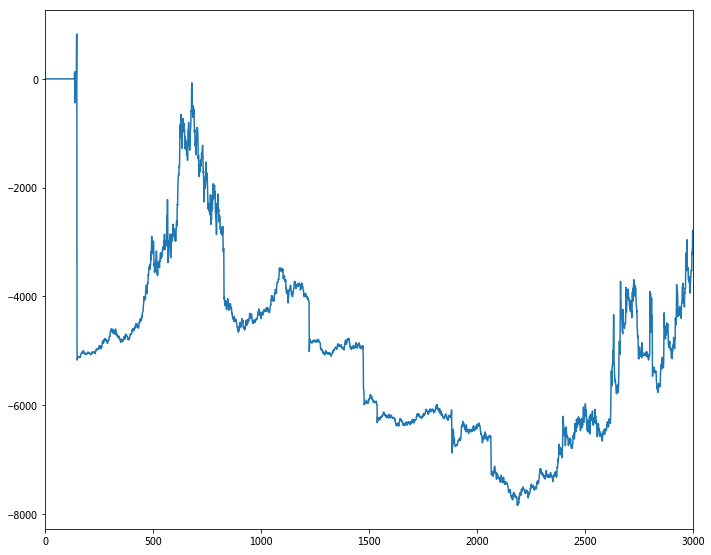

In [50]:
#绘制资金收益曲线

x = my_tm.getProfitCurve(stk.getDatetimeList(q), KQuery.DAY)
x = PRICELIST(x)
x.plot()

In [242]:
#回测统计
from datetime import datetime

per = Performance()
#print(per.report(my_tm, Datetime(datetime.today())))
per.statistics(my_tm, Datetime.now())
x = per.get("当前总资产".encode('gb2312'))
print(x)

1021660.42


In [51]:
def calTotal(blk, q):
    per = Performance()
    x = []
    for stk in blk:
        my_sys.run(stk, q)
        per.statistics(my_tm, Datetime.now())
        x.append(per.get("当前总资产".encode('gb2312')))
    return x

x = calTotal(blocka, q)


In [52]:
y = PRICELIST(x).to_df()

In [53]:
y = y / 10000
y.describe()

,IndicatorImp
count,3566.000000
mean,9.965680
std,0.760362
min,7.409241
25%,9.652344
50%,9.937806
75%,10.142511
max,23.280772
